In [ ]:
!python -m spacy download pt_core_news_sm
!python -m spacy download en
!pip install spacy
!pip install beautifulsoup4

✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [ ]:
import nltk
import spacy
from spacy import displacy
import tqdm
import operator
import requests
from bs4 import BeautifulSoup
import re
import pt_core_news_sm
import en_core_web_sm
from collections import Counter
import random
import operator
import matplotlib.pyplot as plt

# Pos tagging

## Abordagem Manual

Em empresas, quando queremos construir/usar um POS Tagging, estamos buscando uma ferramenta para trabalhar em algum cenário específico e direcionado ao negócio. Por exemplo, recuperar todos os verbos de um texto, para analisar de forma geral as ações que um cliente conecta com a marca no Twitter. Nesse sentido, podemos usar duas abordagens:

    1 - Construir um modelo próprio que resolva esse cenário
    2 - Usar modelos que já existem e, se necessário, treiná-los para melhor performance no nosso cenário

Para esse exercício, vamos simular esse cenário de recuperar verbos de um texto. Apesar da abordagem 2 parecer mais interessante, vamos tentar construir nosso próprio modelo e aprender um pouco sobre a complexidade do problema.

Inicialmente, vamos reduzir bem nosso escopo, focando em

    - REGEX com NamedGoups
    - Verbos simples, como estudar
    
Use o método abaixo para verificar quais grupos foram identificados pela expressão regular:

```python
def print_found_groups(pattern, phrase):
    regex = re.compile(pattern)
    for m in regex.finditer(phrase):
        print({k:v for(k,v) in m.groupdict().items() if v is not None})
```

Mais informações de regex: https://docs.python.org/pt-br/3.8/howto/regex.html

In [ ]:
def print_found_groups(pattern, phrase):
    regex = re.compile(pattern)
    for m in regex.finditer(phrase):
        print({k:v for(k,v) in m.groupdict().items() if v is not None})

In [ ]:
phrase1 = "eu estudo, você estuda, nós estudamos e vc sabe como é... estudos em todo lugar "

In [ ]:
estudar_pattern_try1 = r'(?P<VERB_ESTUDAR>\bestud\w?\b)'

In [ ]:
print_found_groups(estudar_pattern_try1, phrase1)

{'VERB_ESTUDAR': 'estudo'}
{'VERB_ESTUDAR': 'estuda'}


<b> Atividade </b>

1) Modifique o padrão da regex para conseguir reconhecer todas as conjugações do verbo estudar na 'phrase1'

In [ ]:
padrao1 = r'(?P<VERB_ESTUDAR>\bestud\w*\b)'

In [ ]:
print_found_groups(padrao1, phrase1)

{'VERB_ESTUDAR': 'estudo'}
{'VERB_ESTUDAR': 'estuda'}
{'VERB_ESTUDAR': 'estudamos'}
{'VERB_ESTUDAR': 'estudos'}


<b> Atividade </b>

2) A solução da atividade 1 trouxe todos verbos? Todas as palavras eram verbos?

Sim a solução trouxe todos os verbos, e todas as palavras que trouxe eram verbos

<b> Atividade </b>

3) Modifique o padrão da regex para identificar todos os verbos da frase abaixo.

```python
phrase2 = "O principal uso que fazemos do canvas é ver e entregar exercícios, além de acessar os materiais postados pelos professores. É importante realizar o acesso todos os dias."
```

Observe que 'acessar' e 'acesso', apesar de serem palavras semelhantes, despenham papéis diferentes. O 'acesso' é um caso claro de polissemia. Observe as duas frases abaixo que isto ficará mais claro:

    - Meu acesso funcionou -> Aqui é substantivo
    - Eu acesso a aula -> Aqui é verbo

Utilize o método abaixo para retornar os grupos de acordo com a expressão regular construída:
```python
def get_found_groups(pattern, phrase):
    regex = re.compile(pattern)
    return {v:k for m in regex.finditer(phrase) for(k,v) in m.groupdict().items() if v is not None }
```

In [ ]:
phrase2 = "O principal uso que fazemos do canvas é ver e entregar exercícios, além de acessar os materiais postados pelos professores. É importante realizar o acesso todos os dias."

In [ ]:
def get_found_groups(pattern, phrase):
    regex = re.compile(pattern)
    return {v:k for m in regex.finditer(phrase) for(k,v) in m.groupdict().items() if v is not None }

In [ ]:
lista_verbos = ['uso', 'usa\w{0,4}', 'faz\w{0,4}', 'é', 'acess\w{1,2}', 'realizar', 'entrega\w{1,2}', "ver" ]

In [ ]:
'|'.join(lista_verbos)

'uso|usa\\w{0,4}|faz\\w{0,4}|é|acess\\w{1,2}|realizar|entrega\\w{1,2}|ver'

In [ ]:
padrao1 = r'(?P<VERBOS>'+"|".join(lista_verbos)+')'

In [ ]:
get_found_groups(padrao1, phrase2)

{'acessar': 'VERBOS',
 'acesso': 'VERBOS',
 'entregar': 'VERBOS',
 'fazemos': 'VERBOS',
 'realizar': 'VERBOS',
 'uso': 'VERBOS',
 'ver': 'VERBOS',
 'é': 'VERBOS'}

<b> Atividade </b>

4) Modifique o padrão da regex para identificar todos os substantivos da frase abaixo.

```python
phrase2 = "O principal uso que fazemos do canvas é ver e entregar exercícios, além de acessar os materiais postados pelos professores. É importante realizar o acesso todos os dias."
```

Utilize o método abaixo para retornar os grupos de acordo com a expressão regular construída:
```python
def get_found_groups(pattern, phrase):
    regex = re.compile(pattern)
    return {v:k for m in regex.finditer(phrase) for(k,v) in m.groupdict().items() if v is not None }
```

In [ ]:
lista_subs = ['canvas', 'professor\w{0,2}', 'exercícios\w{0,1}', 'materia\w{0,2}', 'acesso\w{0,1}', "dia\w{0,1}" ]

In [ ]:
padrao2 = r'(?P<SUBS>'+"|".join(lista_subs)+')'

In [ ]:
get_found_groups(padrao2, phrase2)

{'acesso': 'SUBS',
 'canvas': 'SUBS',
 'dias': 'SUBS',
 'exercícios': 'SUBS',
 'materiais': 'SUBS',
 'professores': 'SUBS'}

<b> Atividade </b>

5) Essa abordagem de construção da regex para taggear as palavras é uma tarefa simples? Qual o valor/aplicação você consegue enxergar para ela?

Não é uma tarefa simples, apenas para uma pequena frase, para um texto maior tomaria muito tempo.

<b> Atividade </b>

6) Nas atividades 3 e 4 você retornou todos os substantivos e verbos da phrase2. Agora marque-os na frase.  O retorno esperado da frase é:

``O principal uso_VERB que fazemos_VERB do canvas é ver_VERB e entregar_VERB exercícios, além de acessar_VERB os materiais postados pelos professores. É importante realizar_VERB o acesso_SUBS|VERB todos os dias.``

Observe que a palavra acesso tem duas tags = SUBS e VERB.

## Mac_Morpho com NLTK

In [ ]:
nltk.download('mac_morpho')
print("WORDS ", nltk.corpus.mac_morpho.tagged_words())
print("______________")
print("SENTS ",nltk.corpus.mac_morpho.tagged_sents())

[nltk_data] Downloading package mac_morpho to /root/nltk_data...
[nltk_data]   Unzipping corpora/mac_morpho.zip.
WORDS  [('Jersei', 'N'), ('atinge', 'V'), ('média', 'N'), ...]
______________
SENTS  [[('Jersei', 'N'), ('atinge', 'V'), ('média', 'N'), ('de', 'PREP'), ('Cr$', 'CUR'), ('1,4', 'NUM'), ('milhão', 'N'), ('em', 'PREP|+'), ('a', 'ART'), ('venda', 'N'), ('de', 'PREP|+'), ('a', 'ART'), ('Pinhal', 'NPROP'), ('em', 'PREP'), ('São', 'NPROP'), ('Paulo', 'NPROP')], [('Programe', 'V'), ('sua', 'PROADJ'), ('viagem', 'N'), ('a', 'PREP|+'), ('a', 'ART'), ('Exposição', 'NPROP'), ('Nacional', 'NPROP'), ('do', 'NPROP'), ('Zebu', 'NPROP'), (',', ','), ('que', 'PRO-KS-REL'), ('começa', 'V'), ('dia', 'N'), ('25', 'N|AP')], ...]


In [ ]:
nltk.corpus.mac_morpho.tagged_sents()[0]

[('Jersei', 'N'),
 ('atinge', 'V'),
 ('média', 'N'),
 ('de', 'PREP'),
 ('Cr$', 'CUR'),
 ('1,4', 'NUM'),
 ('milhão', 'N'),
 ('em', 'PREP|+'),
 ('a', 'ART'),
 ('venda', 'N'),
 ('de', 'PREP|+'),
 ('a', 'ART'),
 ('Pinhal', 'NPROP'),
 ('em', 'PREP'),
 ('São', 'NPROP'),
 ('Paulo', 'NPROP')]

In [ ]:
words_tagged = nltk.corpus.mac_morpho.tagged_words()

<b> Atividade </b>

7) Gere a quantidade de itens de cada tag no mac_morpho

In [ ]:
lista_tags = []
for palavra in words_tagged:
  lista_tags.append(palavra[1])

In [ ]:
lista_tags = dict(Counter(lista_tags))

In [ ]:
sorted(lista_tags.items(), key=operator.itemgetter(1), reverse=True)

[('N', 236462),
 ('ART', 151891),
 ('NPROP', 114318),
 ('PREP', 104364),
 ('V', 98056),
 ('PREP|+', 78274),
 (',', 68494),
 ('ADJ', 53372),
 ('ADV', 30653),
 ('KC', 28262),
 ('PCP', 23092),
 ('"', 21069),
 ('PROADJ', 20919),
 ('NUM', 18110),
 ('VAUX', 17832),
 ('PROPESS', 14718),
 ('KS', 14320),
 ('PRO-KS-REL', 11347),
 ('PROSUB', 8598),
 (')', 7741),
 ('(', 7713),
 ('PDEN', 6786),
 (':', 6736),
 ('N|AP', 4350),
 ('-', 3117),
 ('N|EST', 2807),
 ('CUR', 2706),
 ('V|+', 2373),
 ('PRO-KS', 2150),
 ('?', 1510),
 (';', 1376),
 ('!', 919),
 ('N|HOR', 913),
 ('ADV-KS-REL', 898),
 ('N|TEL', 866),
 ("'", 510),
 ('IN', 415),
 ('ADV-KS', 392),
 ('N|DAT', 285),
 ('N|DAD', 255),
 ('ADJ|EST', 174),
 ('KC|[', 143),
 ('KC|]', 133),
 ('VAUX|+', 99),
 ('/', 95),
 ('...', 84),
 ('.', 82),
 ('$', 60),
 ('NPROP|+', 35),
 ('[', 23),
 ('PREP|[', 20),
 ('ADV|[', 18),
 ('=', 14),
 ('ADV|]', 13),
 ('ADJ|+', 11),
 ('((', 10),
 ('))', 10),
 ('PREP|]', 9),
 ('ADV|EST', 9),
 ('ADV|HOR', 9),
 ('ADV|+', 8),
 ('ART|+'

8) Quais são as tags mais com maior frequência? E quais com menor? Esse resultado faz sentido?

Maior frequência: Substantivo e artigo. faz sentido pois são duas das classes mais comuns

## POS Tagging com Spacy - Desambiguando frases

Uma das aplicações do pos tagging é auxiliar na desambiguação de palavras. Uma mesma palavra pode desempenhar funções semântias diferentes, dependendo do contexto.

<b> Atividade </b>

9) Considere as frases abaixo:

9.1) frases grupo1:
```python
frase0="Ele foi andar"
frase1="O andar estava triste"
```

9.2) frase grupo2:
```python
frase2="Essa cola cola papel"
```
9.3) frases grupo3:
```python
frase3="Hora de fazer imposto de renda"
frase4="Aquilo foi imposto pelo chefe"
```

9.4) frases grupo4:
```python
frase5="Hora de fazer imposto de renda"
frase6="Aquilo foi imposto pelo chefe"
```

9.5) frases grupo5:
```python
frase7="Todo dia eu caminho"
frase8="Esse é o caminho mais fácil"
```

Utilizando o modelo ``pt_core_news_sm`` da biblioteca spacy faça as seguinte análises. Para cada token:

- a) imprima a função sintática (pos-tagging) em texto
- b) relação de dependência sintática em texto
- c) gera uma imagem das relações acims utilizando o método abaixo:
- d) análise a palavra em comum, descreva a diferença sintática encontrada e responda se é gramaticamente correta

```python
#Para imprimir detalhes
displacy.render(doc, style='dep',jupyter=True)

```

Dica: https://spacy.io/api/annotation

In [ ]:
nlp = pt_core_news_sm.load()

<b> Atividade </b>

9.1 Frases Grupo 1

In [ ]:
txt0="Ele foi andar"
txt1="O andar estava triste"

In [ ]:
def analisa(texto):
  texto_nlp = nlp(texto)
  for token in texto_nlp:
    print('Token: ', token.text, "\ta) Tag: ", token.pos_, '\t\tb) Dep:', token.dep_)
  print("c)")
  displacy.render(texto_nlp, style='dep',jupyter=True)


In [ ]:
analisa(txt0)

Token:  Ele 	a) Tag:  PRON 		b) Dep: nsubj:pass
Token:  foi 	a) Tag:  AUX 		b) Dep: aux:pass
Token:  andar 	a) Tag:  VERB 		b) Dep: ROOT
c)


In [ ]:
txt_nlp = nlp(txt0)

In [ ]:
txt_nlp[0].pos_

'PRON'

In [ ]:
displacy.render(txt_nlp, style='dep',jupyter=True)

<b> d) Disucussão Grupo 1: </b>

<b> Atividade </b>

9.2. Frase Grupo 2

In [ ]:
txt2="Essa cola cola papel"

In [ ]:
analisa(txt2)

Token:  Essa 	a) Tag:  DET 		b) Dep: det
Token:  cola 	a) Tag:  NOUN 		b) Dep: ROOT
Token:  cola 	a) Tag:  ADJ 		b) Dep: flat:name
Token:  papel 	a) Tag:  PROPN 		b) Dep: flat:name
c)


<b> d) Disucussão Grupo 2: </b>

<b> Atividade </b>

9.3. Frases Grupo 3

In [ ]:
txt3="Segundo o que me disseram, ele estava triste"
txt4="No segundo dia de trabalho ela gastou menos"

In [ ]:
analisa(txt3)

Token:  Segundo 	a) Tag:  ADP 		b) Dep: case
Token:  o 	a) Tag:  PRON 		b) Dep: obl
Token:  que 	a) Tag:  PRON 		b) Dep: nsubj
Token:  me 	a) Tag:  PRON 		b) Dep: iobj
Token:  disseram 	a) Tag:  VERB 		b) Dep: acl:relcl
Token:  , 	a) Tag:  PUNCT 		b) Dep: punct
Token:  ele 	a) Tag:  PRON 		b) Dep: nsubj
Token:  estava 	a) Tag:  VERB 		b) Dep: cop
Token:  triste 	a) Tag:  ADJ 		b) Dep: ROOT
c)


In [ ]:
analisa(txt4)

Token:  No 	a) Tag:  ADP 		b) Dep: case
Token:  segundo 	a) Tag:  ADJ 		b) Dep: amod
Token:  dia 	a) Tag:  NOUN 		b) Dep: obl
Token:  de 	a) Tag:  ADP 		b) Dep: case
Token:  trabalho 	a) Tag:  NOUN 		b) Dep: nmod
Token:  ela 	a) Tag:  PRON 		b) Dep: nsubj
Token:  gastou 	a) Tag:  VERB 		b) Dep: ROOT
Token:  menos 	a) Tag:  ADV 		b) Dep: advmod
c)


<b> d) Disucussão Grupo 3: </b>

<b> Atividade </b>

9.4. Frases Grupo 4

In [ ]:
txt5="Hora de fazer imposto de renda"
txt6="Aquilo foi imposto pelo chefe"

In [ ]:
analisa(txt5)

Token:  Hora 	a) Tag:  NOUN 		b) Dep: ROOT
Token:  de 	a) Tag:  ADP 		b) Dep: mark
Token:  fazer 	a) Tag:  VERB 		b) Dep: acl
Token:  imposto 	a) Tag:  NOUN 		b) Dep: obj
Token:  de 	a) Tag:  ADP 		b) Dep: case
Token:  renda 	a) Tag:  NOUN 		b) Dep: nmod
c)


In [ ]:
analisa(txt6)

Token:  Aquilo 	a) Tag:  PRON 		b) Dep: nsubj:pass
Token:  foi 	a) Tag:  AUX 		b) Dep: aux:pass
Token:  imposto 	a) Tag:  VERB 		b) Dep: ROOT
Token:  pelo 	a) Tag:  ADP 		b) Dep: case
Token:  chefe 	a) Tag:  NOUN 		b) Dep: obl
c)


<b> d) Disucussão Grupo 4: </b>

<b> Atividade </b>

9.5. Frases Grupo 5

In [ ]:
txt7="Todo dia eu caminho"
txt8="Esse é o caminho mais fácil"

In [ ]:
analisa(txt7)

Token:  Todo 	a) Tag:  DET 		b) Dep: det
Token:  dia 	a) Tag:  NOUN 		b) Dep: obl
Token:  eu 	a) Tag:  PRON 		b) Dep: nsubj
Token:  caminho 	a) Tag:  VERB 		b) Dep: ROOT
c)


In [ ]:
analisa(txt8)

Token:  Esse 	a) Tag:  PRON 		b) Dep: nsubj
Token:  é 	a) Tag:  VERB 		b) Dep: cop
Token:  o 	a) Tag:  DET 		b) Dep: det
Token:  caminho 	a) Tag:  NOUN 		b) Dep: ROOT
Token:  mais 	a) Tag:  ADV 		b) Dep: advmod
Token:  fácil 	a) Tag:  ADJ 		b) Dep: amod
c)


<b> d) Disucussão Grupo 5: </b>

<b> Esse modelo do spacy para português, em 79,94 de acurácia no pos-tagging</b>

<b> Atividade </b>

10) Sabendo que o modelo que estamos utulizando possui acurácia de 79,94 no pos-tagging, encontre um exemplo que ele falhe.

In [ ]:
frase = "Oi, tudo bem com você?"

In [ ]:
analisa(frase)

Token:  Oi 	a) Tag:  VERB 		b) Dep: ROOT
Token:  , 	a) Tag:  PUNCT 		b) Dep: punct
Token:  tudo 	a) Tag:  PRON 		b) Dep: appos
Token:  bem 	a) Tag:  ADV 		b) Dep: advmod
Token:  com 	a) Tag:  ADP 		b) Dep: case
Token:  você 	a) Tag:  PRON 		b) Dep: nmod
Token:  ? 	a) Tag:  PUNCT 		b) Dep: punct
c)


# Named Entity Recognition

## Recomendação de sites

<b> Atividade </b>

11) Capture o texto de cada notícia abaixo:

- 0 -> https://g1.globo.com/sp/sao-paulo/noticia/2020/03/03/cai-para-130-numero-de-casos-suspeitos-de-coronavirus-no-estado-de-sao-paulo.ghtml
- 1 -> https://g1.globo.com/sp/sao-paulo/noticia/2020/03/04/ministerio-da-saude-confirma-terceiro-paciente-com-coronavirus-em-sp-um-quarto-caso-aguarda-contraprova.ghtml
- 2 -> https://g1.globo.com/bemestar/coronavirus/noticia/2020/03/04/ultimas-noticias-de-coronavirus-de-4-de-marco.ghtml
- 3 -> https://g1.globo.com/economia/noticia/2020/03/04/projetos-reduzem-em-r-96-bilhoes-emendas-parlamentares-no-orcamento-2020-diz-governo.ghtml
- 4 -> https://g1.globo.com/politica/noticia/2020/03/04/documento-liga-assessor-de-eduardo-bolsonaro-a-conta-em-rede-social-para-ataques-pessoais.ghtml
- 5 -> https://g1.globo.com/rj/rio-de-janeiro/noticia/2020/03/04/flavio-bolsonaro-entra-com-recurso-para-tentar-paralisar-investigacao-sobre-suspeita-de-rachadinha.ghtml
- 6 -> https://g1.globo.com/economia/noticia/2020/03/04/pib-do-brasil-cresce-11percent-em-2019.ghtml
- 7 -> https://g1.globo.com/economia/noticia/2020/03/04/tudo-dentro-do-previsto-diz-paulo-guedes-sobre-resultado-do-pib.ghtml
- 8 -> https://g1.globo.com/sp/santos-regiao/noticia/2020/03/04/sobe-numero-de-mortos-apos-temporal-na-baixada-santista.ghtml
- 9 -> https://g1.globo.com/sp/sao-paulo/noticia/2020/03/04/ministerio-da-saude-confirma-terceiro-paciente-com-coronavirus-em-sp-um-quarto-caso-aguarda-contraprova.ghtml

Para isto utilize o código abaixo:
```python
def match_class(target):                                                        
    def do_match(tag):                                                          
        classes = tag.get('class', [])                                          
        return all(c in classes for c in target)                                
    return do_match

def get_text_url(url):
    res = requests.get(url)
    html = res.text
    soup = BeautifulSoup(html, 'html5lib')
    #remove marcações de scripts e style
    texto = soup.find_all(match_class(["content-text__container"]))
    all_text = ""
    for t in texto:
        all_text += t.get_text()
    return all_text
```

In [ ]:
def match_class(target):
    def do_match(tag):
        classes = tag.get('class', [])
        return all(c in classes for c in target)
    return do_match

def get_text_url(url):
    res = requests.get(url)
    html = res.text
    soup = BeautifulSoup(html, 'html5lib')
    #remove marcações de scripts e style
    texto = soup.find_all(match_class(["content-text__container"]))
    all_text = ""
    for t in texto:
        all_text += t.get_text()
    return all_text

In [ ]:
get_text_url("https://g1.globo.com/sp/sao-paulo/noticia/2020/03/03/cai-para-130-numero-de-casos-suspeitos-de-coronavirus-no-estado-de-sao-paulo.ghtml")

' A Secretaria Estadual de Saúde de São Paulo divulgou nesta terça-feira (3) que caiu o número de pacientes com suspeita de coronavírus no estado. Enquanto na segunda-feira (2) eram 163 casos suspeitos, nesta terça são 130.  Foram descartados, ao todo, 104 casos no estado, destes, 56 foram nas últimas 24 horas. Entretanto, segundo informou a pasta, entre segunda (2) e terça (3), 23 novos surgiram.  Permanecem confirmados apenas 2 casos da doença no país, ambos no estado de São Paulo. Os pacientes estão em quarentena domiciliar. Ambos estiveram em viagem na Itália.  "Os dois confirmados estão evoluindo bem clinicamente, mas ainda têm alguns sintomas que fazem com que eles continuem em isolamento domiciliar", salientou Paulo Menezes, coordenador do comitê de operações emergenciais (COE) da Secretaria Estadual de Saúde.  O número de pessoas que tiveram contato com o segundo caso confirmado não foi divulgado pela secretaria. No primeiro caso confirmado, eram 34 pessoas, entre passageiros d

In [ ]:
noticias = {}
noticias[0] = 'https://g1.globo.com/sp/sao-paulo/noticia/2020/03/03/cai-para-130-numero-de-casos-suspeitos-de-coronavirus-no-estado-de-sao-paulo.ghtml'
noticias[1] = 'https://g1.globo.com/sp/sao-paulo/noticia/2020/03/04/ministerio-da-saude-confirma-terceiro-paciente-com-coronavirus-em-sp-um-quarto-caso-aguarda-contraprova.ghtml'
noticias[2] = 'https://g1.globo.com/bemestar/coronavirus/noticia/2020/03/04/ultimas-noticias-de-coronavirus-de-4-de-marco.ghtml'
noticias[3] = 'https://g1.globo.com/economia/noticia/2020/03/04/projetos-reduzem-em-r-96-bilhoes-emendas-parlamentares-no-orcamento-2020-diz-governo.ghtml'
noticias[4] = 'https://g1.globo.com/politica/noticia/2020/03/04/documento-liga-assessor-de-eduardo-bolsonaro-a-conta-em-rede-social-para-ataques-pessoais.ghtml'
noticias[5] = 'https://g1.globo.com/rj/rio-de-janeiro/noticia/2020/03/04/flavio-bolsonaro-entra-com-recurso-para-tentar-paralisar-investigacao-sobre-suspeita-de-rachadinha.ghtml'
noticias[6] = 'https://g1.globo.com/economia/noticia/2020/03/04/pib-do-brasil-cresce-11percent-em-2019.ghtml'
noticias[7] = 'https://g1.globo.com/economia/noticia/2020/03/04/tudo-dentro-do-previsto-diz-paulo-guedes-sobre-resultado-do-pib.ghtml'
noticias[8] = 'https://g1.globo.com/sp/santos-regiao/noticia/2020/03/04/sobe-numero-de-mortos-apos-temporal-na-baixada-santista.ghtml'
noticias[9] = 'https://g1.globo.com/sp/sao-paulo/noticia/2020/03/04/ministerio-da-saude-confirma-terceiro-paciente-com-coronavirus-em-sp-um-quarto-caso-aguarda-contraprova.ghtml'


In [ ]:
texto_noticias = {i:get_text_url(noticias[i]) for i in noticias.keys()}

In [ ]:
texto_noticias

{0: ' A Secretaria Estadual de Saúde de São Paulo divulgou nesta terça-feira (3) que caiu o número de pacientes com suspeita de coronavírus no estado. Enquanto na segunda-feira (2) eram 163 casos suspeitos, nesta terça são 130.  Foram descartados, ao todo, 104 casos no estado, destes, 56 foram nas últimas 24 horas. Entretanto, segundo informou a pasta, entre segunda (2) e terça (3), 23 novos surgiram.  Permanecem confirmados apenas 2 casos da doença no país, ambos no estado de São Paulo. Os pacientes estão em quarentena domiciliar. Ambos estiveram em viagem na Itália.  "Os dois confirmados estão evoluindo bem clinicamente, mas ainda têm alguns sintomas que fazem com que eles continuem em isolamento domiciliar", salientou Paulo Menezes, coordenador do comitê de operações emergenciais (COE) da Secretaria Estadual de Saúde.  O número de pessoas que tiveram contato com o segundo caso confirmado não foi divulgado pela secretaria. No primeiro caso confirmado, eram 34 pessoas, entre passageir

<b> Atividade </b>

12) Capture as entidades de cada uma das notícias utilizando o modelo ``pt_core_news_sm`` do spacy.

<i> Dica: ents retorna as entidades de um texto </i>

In [ ]:
nlp = pt_core_news_sm.load()

In [ ]:
texto_nlp = {i:nlp(texto_noticias[i]) for i in texto_noticias.keys()}

In [ ]:
entidades = {i:set(map(str, texto_nlp[0].ents)) for i in texto_noticias.keys()}

In [ ]:
texto_nlp.ents

(A Secretaria Estadual de Saúde de São Paulo,
 estado de São Paulo,
 Itália,
 Paulo Menezes,
 COE,
 Secretaria Estadual de Saúde,
 Paulo Menezes,
 COE,
 José Henrique Germann,
 Centro de Contingenciamento de Emergências,
 David Uip,
 José Henrique Germann,
 Helena Sato,
 Centro de Vigilância Epidemiológica,
 CVE,
 Uip,
 Adolfo Lutz,
 Menezes,
 Secretaria Estadual de Saúde,
 Secretaria Estadual de Saúde,
 Ministério da Saúde,
 São Paulo,
 Milão,
 Itália,
 Menezes,
 Saúde,
 Uip,
 Organização Mundial de Saúde,
 OMS,
 R$,
 David Uip,
 Instituto Butantan,
 Secretário de Estado da Saúde,
 José Henrique Germann,
 Campanha Nacional de Vacinação)

<b> Atividade </b>

13) Quais são as 5 entidades que mais apareceram nas notíciais? Critique esse resultado, ele faz sentido?

In [ ]:
todas_entidade = []

In [ ]:
for k in entidades.keys():
  todas_entidade.extend(entidades[k])

In [ ]:
todas_entidades =  dict(Counter(todas_entidade))

In [ ]:
sorted(todas_entidades.items(), key=operator.itemgetter(1))

[('Secretaria Estadual de Saúde', 10),
 ('CVE', 10),
 ('Saúde', 10),
 ('Adolfo Lutz', 10),
 ('OMS', 10),
 ('Uip', 10),
 ('Secretário de Estado da Saúde', 10),
 ('R$', 10),
 ('Instituto Butantan', 10),
 ('Organização Mundial de Saúde', 10),
 ('Centro de Vigilância Epidemiológica', 10),
 ('A Secretaria Estadual de Saúde de São Paulo', 10),
 ('Paulo Menezes', 10),
 ('Centro de Contingenciamento de Emergências', 10),
 ('David Uip', 10),
 ('Ministério da Saúde', 10),
 ('Helena Sato', 10),
 ('estado de São Paulo', 10),
 ('Menezes', 10),
 ('José Henrique Germann', 10),
 ('COE', 10),
 ('São Paulo', 10),
 ('Itália', 10),
 ('Milão', 10),
 ('Campanha Nacional de Vacinação', 10)]

<b> Atividade </b>

14) Para a notítica 0, imprima quais foram os tipos das entidades encontradas e plote um gráfico com esses dados.
Faça uma análise desse resultado

<i> Dica: label_ retorna o nome da entidade </i>

In [ ]:
ents_noticia0 = Counter([ent.label_ for ent in texto_nlp[0].ents])

In [ ]:
dict(ents_noticia0)

{'LOC': 10, 'MISC': 4, 'ORG': 8, 'PER': 13}

<BarContainer object of 4 artists>

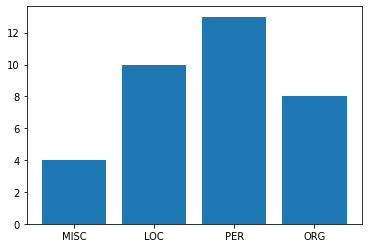

In [ ]:
plt.bar(ents_noticia0.keys(), ents_noticia0.values())

<b> Atividade </b>

15) Plote um gráfico com esses dados com todos os tipos das entidades de todas as notícias. Compare este resultado com o resultado da notícia 0.

<b> Atividade </b>

16) Imprima a notícia 0, colorindo as entidades encontradas, para isto utilize o método abaixo:

```python
displacy.render(doc, jupyter=True, style='ent')
```

<i> Dica: entidades que existem no spacy https://spacy.io/api/annotation#section-named-entities

Caso tenha dúvida sobre alguma marcalçao use:</i>

```python
spacy.explain("MISC")
```

In [ ]:
spacy.explain("ORG")

'Companies, agencies, institutions, etc.'

In [ ]:
displacy.render(texto_nlp[0], jupyter=True, style='ent')

<b> Atividade </b>

17) Seja o documento 0 sua referência. Calcule a similaridade das entidades do documento 0 com todos outros 9. Para calcular a similaridade utilize o método jacard (implementado na aula 3).

In [ ]:
def jaccard_similarity(list1, list2):
  s1 = set(list1)
  s2 = set(list2)
  return len(s1.intersection(s2)) / len(s1.union(s2))


In [ ]:
for i in range(1, 10):
  print(" 0 e ", i, '=',jaccard_similarity(entidades[0], entidades[i]))

 0 e  1 = 1.0
 0 e  2 = 1.0
 0 e  3 = 1.0
 0 e  4 = 1.0
 0 e  5 = 1.0
 0 e  6 = 1.0
 0 e  7 = 1.0
 0 e  8 = 1.0
 0 e  9 = 1.0


<b> Atividade </b>

18) Com os cálculos da questão anterior, responda: quais foram os três documentos com maior similaridade? Eles posssuem conteúdos semelhantes? E qual o documento com menor similaridade? Este documento faz sentido?

Todos tiveram mesma similaridade

## Retreino NER

Aqui nós iremos ilustrar como treinar um modelo NER no spacy

In [ ]:
nlp = pt_core_news_sm.load()

In [ ]:
texto = "João nasceu em Paris em 01/01/2000"

In [ ]:
texto_nlp = nlp(texto)

In [ ]:
displacy.render(texto_nlp, style='ent',jupyter=True)

Observe que o modelo identifica <b> João </b> como pessoa e <b> Paris </b> como localidade.

Apesar do modelo ter identificado essas duas entidades ele naõ identificou a <b> data </b>.

Assim, aqui iremos mostrar como retreinar o modelo para capturar também a data.


In [ ]:
#dados de treino. Note que para cada frase, a posição de uma determinada entidade.
train_data = [
("Em 04/12/1992 nasceu Joana", {'entities':[(3, 13, "DATE"), (21,26, "PER")]}),
("Data de início: 10/01/2018", {'entities':[(16, 26, "DATE")]}),
("Maria se mudou para Paris", {'entities':[(20,26, "LOC")]}),
("Paris cidade das luzes", {'entities':[(0,5, "LOC")]}),
("Maria nasceu em Contagem no dia 07/05/2018", {'entities':[(0,5,"PER"),(16,24,"LOC"),(32,42, "DATE")]})
]

### Retreino

- explosion/spaCy/master/examples/training/train_ner.py -> O spcay disponibiliza esse código para treinamentos.
- Mais informações? https://spacy.io/usage/training

In [ ]:
def train_spacy(data, iterations):
    TRAIN_DATA = data
    nlp = spacy.blank('pt')  # create blank Language class
    # create the built-in pipeline components and add them to the pipeline
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if 'ner' not in nlp.pipe_names:
        ner = nlp.create_pipe('ner')
        nlp.add_pipe(ner, last=True)


    # add labels
    for _, annotations in TRAIN_DATA:
         for ent in annotations.get('entities'):
            ner.add_label(ent[2])

    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
    with nlp.disable_pipes(*other_pipes):  # only train NER
        optimizer = nlp.begin_training()
        for itn in range(iterations):
            random.shuffle(TRAIN_DATA)
            losses = {}
            for text, annotations in TRAIN_DATA:
                nlp.update(
                    [text],  # batch of texts
                    [annotations],  # batch of annotations
                    drop=0.2,  # dropout - make it harder to memorise data
                    sgd=optimizer,  # callable to update weights
                    losses=losses)
    return nlp

In [ ]:
modelo_novo = train_spacy(train_data, 30)

In [ ]:
modelo_novo.to_disk("modelo_novo_NER")

<b> Atividade </b>

19) O ``modelo_novo`` já foi criado. Aplique o texto em que demonstramos que a data não foi identificada e depois imprima utilizando o ``displacy``.
O problema foi resolvido? E se mudarmos o formato da data, ele reconhce? Quais outras entidades o modelo não consegue reconhecer?

In [ ]:
texto_nlp = modelo_novo(texto)

In [ ]:
texto_nlp

João nasceu em Paris em 01/01/2000

In [ ]:
displacy.render(texto_nlp, style='ent', jupyter=True)